#Disease Prediction from Symptoms

The dataset source: http://people.dbmi.columbia.edu/~friedma/Projects/DiseaseSymptomKB/index.html

The extraction was performed by copying the data on the website in the .html format and saving it in an Excel file for performing further operations. Basic cleaning, segmentation of columns and string formatting were performed in excel. The excel sheet was then added to this Google Colab Notebook.



##Importing all needed libraries

In [ ]:
# Import Dependencies
import csv
import pandas as pd
import numpy as np
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Transforming & Loading the Data

### Loading the Dataset File generated after preprocessing in excel

In [ ]:
disease_list = []

def return_list(disease):
    disease_list = []
    match = disease.replace('^','_').split('_') # using _ as common splitting delimeter
    ctr = 1
    for group in match:
        if ctr%2==0:
            disease_list.append(group) # refer the data format
        ctr = ctr + 1

    return disease_list

with open("raw_data_2.csv") as csvfile:
    reader = csv.reader(csvfile)
    disease=""
    weight = 0
    disease_list = []
    dict_wt = {}
    dict_=defaultdict(list)
    
    for row in reader:

        if row[0]!="\xc2\0xa0" and row[0]!="": # for handling file encoding errors
          # saving disease and frequency
            disease = row[0]
            disease_list = return_list(disease)
            weight = row[1]

        if row[2]!="\xc2\0xa0" and row[2]!="":
            symptom_list = return_list(row[2])

            for d in disease_list:
                for s in symptom_list:
                    dict_[d].append(s) # adding all symptoms
                dict_wt[d] = weight


### Reformatting the data

In [ ]:
# saving cleaned data
with open("dataset_clean.csv","w") as csvfile:
    writer = csv.writer(csvfile)
    for key,values in dict_.items():
        for v in values:
            #key = str.encode(key)
            key = str.encode(key).decode('utf-8')
            #.strip()
            #v = v.encode('utf-8').strip()
            #v = str.encode(v)
            writer.writerow([key,v,dict_wt[key]])

In [ ]:
columns = ['Source','Target','Weight'] # source: disease, target: symptom, weight: number of cases

In [ ]:
data = pd.read_csv("dataset_clean.csv",names=columns, encoding ="ISO-8859-1")

In [ ]:
data.head()

,Source,Target,Weight
0,hypertensive disease,pain chest,3363
1,hypertensive disease,shortness of breath,3363
2,hypertensive disease,dizziness,3363
3,hypertensive disease,asthenia,3363
4,hypertensive disease,fall,3363


In [ ]:
data.to_csv("dataset_clean.csv",index=False)

In [ ]:
data = pd.read_csv("dataset_clean.csv", encoding ="ISO-8859-1")

In [ ]:
data.head()

,Source,Target,Weight
0,hypertensive disease,pain chest,3363
1,hypertensive disease,shortness of breath,3363
2,hypertensive disease,dizziness,3363
3,hypertensive disease,asthenia,3363
4,hypertensive disease,fall,3363


In [ ]:
len(data['Source'].unique()) # unique diseases

149

In [ ]:
len(data['Target'].unique()) # unique symptoms

405

In [ ]:
df = pd.DataFrame(data)

In [ ]:
df_1 = pd.get_dummies(df.Target) # 1 hot encoding symptoms

In [ ]:
df_1.head()

,Heberden's node,Murphy's sign,Stahli's line,abdomen acute,abdominal bloating,abdominal tenderness,abnormal sensation,abnormally hard consistency,abortion,abscess bacterial,absences finding,achalasia,ache,adverse effect,adverse reaction,agitation,air fluid level,alcohol binge episode,alcoholic withdrawal symptoms,ambidexterity,angina pectoris,anorexia,anosmia,aphagia,apyrexial,arthralgia,ascites,asterixis,asthenia,asymptomatic,ataxia,atypia,aura,awakening early,barking cough,bedridden,behavior hyperactive,behavior showing increased motor activity,blackout,blanch,...,tenesmus,terrify,thicken,throat sore,throbbing sensation quality,tinnitus,tired,titubation,todd paralysis,tonic seizures,transaminitis,transsexual,tremor,tremor resting,tumor cell invasion,unable to concentrate,unconscious state,uncoordination,underweight,unhappy,unresponsiveness,unsteady gait,unwell,urge incontinence,urgency ofÃÂ micturition,urinary hesitation,urinoma,verbal auditory hallucinations,verbally abusive behavior,vertigo,vision blurred,vomiting,weepiness,weight gain,welt,wheelchair bound,wheezing,withdraw,worry,yellow sputum
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.head()

,Source,Target,Weight
0,hypertensive disease,pain chest,3363
1,hypertensive disease,shortness of breath,3363
2,hypertensive disease,dizziness,3363
3,hypertensive disease,asthenia,3363
4,hypertensive disease,fall,3363


In [ ]:
df_s = df['Source']

In [ ]:
df_pivoted = pd.concat([df_s,df_1], axis=1)

In [ ]:
df_pivoted.drop_duplicates(keep='first',inplace=True)

In [ ]:
df_pivoted[:5]

,Source,Heberden's node,Murphy's sign,Stahli's line,abdomen acute,abdominal bloating,abdominal tenderness,abnormal sensation,abnormally hard consistency,abortion,abscess bacterial,absences finding,achalasia,ache,adverse effect,adverse reaction,agitation,air fluid level,alcohol binge episode,alcoholic withdrawal symptoms,ambidexterity,angina pectoris,anorexia,anosmia,aphagia,apyrexial,arthralgia,ascites,asterixis,asthenia,asymptomatic,ataxia,atypia,aura,awakening early,barking cough,bedridden,behavior hyperactive,behavior showing increased motor activity,blackout,...,tenesmus,terrify,thicken,throat sore,throbbing sensation quality,tinnitus,tired,titubation,todd paralysis,tonic seizures,transaminitis,transsexual,tremor,tremor resting,tumor cell invasion,unable to concentrate,unconscious state,uncoordination,underweight,unhappy,unresponsiveness,unsteady gait,unwell,urge incontinence,urgency ofÃÂ micturition,urinary hesitation,urinoma,verbal auditory hallucinations,verbally abusive behavior,vertigo,vision blurred,vomiting,weepiness,weight gain,welt,wheelchair bound,wheezing,withdraw,worry,yellow sputum
0,hypertensive disease,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,hypertensive disease,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,hypertensive disease,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,hypertensive disease,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,hypertensive disease,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
len(df_pivoted)

2116

In [ ]:
cols = df_pivoted.columns

In [ ]:
cols = cols[1:] # removing headings

In [ ]:
# visualizing existance of symptoms for diseases
df_pivoted = df_pivoted.groupby('Source').sum()
df_pivoted = df_pivoted.reset_index()
df_pivoted[:5]

,Source,Heberden's node,Murphy's sign,Stahli's line,abdomen acute,abdominal bloating,abdominal tenderness,abnormal sensation,abnormally hard consistency,abortion,abscess bacterial,absences finding,achalasia,ache,adverse effect,adverse reaction,agitation,air fluid level,alcohol binge episode,alcoholic withdrawal symptoms,ambidexterity,angina pectoris,anorexia,anosmia,aphagia,apyrexial,arthralgia,ascites,asterixis,asthenia,asymptomatic,ataxia,atypia,aura,awakening early,barking cough,bedridden,behavior hyperactive,behavior showing increased motor activity,blackout,...,tenesmus,terrify,thicken,throat sore,throbbing sensation quality,tinnitus,tired,titubation,todd paralysis,tonic seizures,transaminitis,transsexual,tremor,tremor resting,tumor cell invasion,unable to concentrate,unconscious state,uncoordination,underweight,unhappy,unresponsiveness,unsteady gait,unwell,urge incontinence,urgency ofÃÂ micturition,urinary hesitation,urinoma,verbal auditory hallucinations,verbally abusive behavior,vertigo,vision blurred,vomiting,weepiness,weight gain,welt,wheelchair bound,wheezing,withdraw,worry,yellow sputum
0,Alzheimer's disease,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,HIV,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,PneumocystisÃÂ cariniiÃÂ pneumonia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,accidentÃÂ cerebrovascular,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,acquiredÃÂ immuno-deficiency syndrome,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
len(df_pivoted)

149

In [ ]:
df_pivoted.to_csv("df_pivoted.csv")

In [ ]:
# defining data for training
x = df_pivoted[cols]
y = df_pivoted['Source']

##Building Model

In [ ]:
# importing all needed libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

In [ ]:
# performing train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [ ]:
# Training multinomial naive bayes
mnb = MultinomialNB()
mnb = mnb.fit(x_train, y_train)

In [ ]:
mnb.score(x_test, y_test)

0.0

###Inferences on train and test split
It can't work on unseen data because it has never seen that disease before. Also, there is only one point for each disease and hence no point for this. So we need to train the model entirely. Then what will we test it on? Missing data? Say given one symptom what is the disease? This is again multilabel classification. We can work symptom on symptom. What exactly is differential diagnosis, we need to replicate that.

In [ ]:
mnb_tot = MultinomialNB()
mnb_tot = mnb_tot.fit(x, y)

In [ ]:
mnb_tot.score(x, y)

0.8993288590604027

In [ ]:
disease_pred = mnb_tot.predict(x)

In [ ]:
disease_real = y.values

In [ ]:
# printing model error
for i in range(0, len(disease_real)):
    if disease_pred[i]!=disease_real[i]:
        print ('Pred: {0} Actual:{1}'.format(disease_pred[i], disease_real[i]))

Pred: HIV Actual:acquiredÃÂ immuno-deficiency syndrome
Pred: biliary calculus Actual:cholelithiasis
Pred: coronary arteriosclerosis Actual:coronary heart disease
Pred: depression mental Actual:depressive disorder
Pred: HIV Actual:hiv infections
Pred: carcinoma breast Actual:malignant neoplasm of breast
Pred: carcinoma of lung Actual:malignant neoplasm of lung
Pred: carcinoma prostate Actual:malignant neoplasm of prostate
Pred: carcinoma colon Actual:malignant tumor of colon
Pred: candidiasis Actual:oralÃÂ candidiasis
Pred: effusion pericardial Actual:pericardial effusion body substance
Pred: malignant neoplasms Actual:primary malignant neoplasm
Pred: sepsis (invertebrate) Actual:septicemia
Pred: sepsis (invertebrate) Actual:systemic infection
Pred: tonic-clonic epilepsy Actual:tonic-clonic seizures


## Using decision trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [ ]:
print ("DecisionTree")
dt = DecisionTreeClassifier()
clf_dt=dt.fit(x,y)
print ("Acurracy: ", clf_dt.score(x,y))

DecisionTree
Acurracy:  0.8993288590604027


In [ ]:
from sklearn import tree 
from sklearn.tree import export_graphviz

export_graphviz(dt, 
                out_file='tree.jpg', 
                feature_names=cols
               )

In [ ]:
from IPython.display import Image
Image(filename='tree.jpg')

##Manual Analysis data

In [ ]:
data = pd.read_csv("Training.csv")

In [ ]:
data.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,muscle_wasting,vomiting,burning_micturition,spotting_ urination,fatigue,weight_gain,anxiety,cold_hands_and_feets,mood_swings,weight_loss,restlessness,lethargy,patches_in_throat,irregular_sugar_level,cough,high_fever,sunken_eyes,breathlessness,sweating,dehydration,indigestion,headache,yellowish_skin,dark_urine,nausea,loss_of_appetite,pain_behind_the_eyes,back_pain,constipation,abdominal_pain,...,internal_itching,toxic_look_(typhos),depression,irritability,muscle_pain,altered_sensorium,red_spots_over_body,belly_pain,abnormal_menstruation,dischromic _patches,watering_from_eyes,increased_appetite,polyuria,family_history,mucoid_sputum,rusty_sputum,lack_of_concentration,visual_disturbances,receiving_blood_transfusion,receiving_unsterile_injections,coma,stomach_bleeding,distention_of_abdomen,history_of_alcohol_consumption,fluid_overload.1,blood_in_sputum,prominent_veins_on_calf,palpitations,painful_walking,pus_filled_pimples,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Fungal infection
1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Fungal infection
2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Fungal infection
3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Fungal infection
4,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Fungal infection


In [ ]:
data.columns

Index(['itching', 'skin_rash', 'nodal_skin_eruptions', 'continuous_sneezing',
       'shivering', 'chills', 'joint_pain', 'stomach_pain', 'acidity',
       'ulcers_on_tongue',
       ...
       'blackheads', 'scurring', 'skin_peeling', 'silver_like_dusting',
       'small_dents_in_nails', 'inflammatory_nails', 'blister',
       'red_sore_around_nose', 'yellow_crust_ooze', 'prognosis'],
      dtype='object', length=133)

In [ ]:
len(data.columns)

133

In [ ]:
len(data['prognosis'].unique())

41

In [ ]:
df = pd.DataFrame(data)

In [ ]:
df.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,muscle_wasting,vomiting,burning_micturition,spotting_ urination,fatigue,weight_gain,anxiety,cold_hands_and_feets,mood_swings,weight_loss,restlessness,lethargy,patches_in_throat,irregular_sugar_level,cough,high_fever,sunken_eyes,breathlessness,sweating,dehydration,indigestion,headache,yellowish_skin,dark_urine,nausea,loss_of_appetite,pain_behind_the_eyes,back_pain,constipation,abdominal_pain,...,internal_itching,toxic_look_(typhos),depression,irritability,muscle_pain,altered_sensorium,red_spots_over_body,belly_pain,abnormal_menstruation,dischromic _patches,watering_from_eyes,increased_appetite,polyuria,family_history,mucoid_sputum,rusty_sputum,lack_of_concentration,visual_disturbances,receiving_blood_transfusion,receiving_unsterile_injections,coma,stomach_bleeding,distention_of_abdomen,history_of_alcohol_consumption,fluid_overload.1,blood_in_sputum,prominent_veins_on_calf,palpitations,painful_walking,pus_filled_pimples,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Fungal infection
1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Fungal infection
2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Fungal infection
3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Fungal infection
4,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Fungal infection


In [ ]:
len(df)

4920

In [ ]:
cols = df.columns

In [ ]:
cols = cols[:-1]

In [ ]:
len(cols)

132

In [ ]:
x = df[cols]
y = df['prognosis']

In [ ]:
x

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,muscle_wasting,vomiting,burning_micturition,spotting_ urination,fatigue,weight_gain,anxiety,cold_hands_and_feets,mood_swings,weight_loss,restlessness,lethargy,patches_in_throat,irregular_sugar_level,cough,high_fever,sunken_eyes,breathlessness,sweating,dehydration,indigestion,headache,yellowish_skin,dark_urine,nausea,loss_of_appetite,pain_behind_the_eyes,back_pain,constipation,abdominal_pain,...,passage_of_gases,internal_itching,toxic_look_(typhos),depression,irritability,muscle_pain,altered_sensorium,red_spots_over_body,belly_pain,abnormal_menstruation,dischromic _patches,watering_from_eyes,increased_appetite,polyuria,family_history,mucoid_sputum,rusty_sputum,lack_of_concentration,visual_disturbances,receiving_blood_transfusion,receiving_unsterile_injections,coma,stomach_bleeding,distention_of_abdomen,history_of_alcohol_consumption,fluid_overload.1,blood_in_sputum,prominent_veins_on_calf,palpitations,painful_walking,pus_filled_pimples,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze
0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4915,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4916,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0
4917,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4918,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0


In [ ]:
y

0                              Fungal infection
1                              Fungal infection
2                              Fungal infection
3                              Fungal infection
4                              Fungal infection
                         ...                   
4915    (vertigo) Paroymsal  Positional Vertigo
4916                                       Acne
4917                    Urinary tract infection
4918                                  Psoriasis
4919                                   Impetigo
Name: prognosis, Length: 4920, dtype: object

## Building Classifier: Using Multinomial Naive Bayes

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [ ]:
mnb = MultinomialNB()
mnb = mnb.fit(x_train, y_train)

In [ ]:
mnb.score(x_test, y_test)

1.0

In [ ]:
from sklearn import model_selection
print ("cross result========")
scores = model_selection.cross_val_score(mnb, x_test, y_test, cv=3)
print (scores)
print (scores.mean())

cross result========
[1. 1. 1.]
1.0


In [ ]:
test_data = pd.read_csv("Testing.csv")

In [ ]:
test_data.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,muscle_wasting,vomiting,burning_micturition,spotting_ urination,fatigue,weight_gain,anxiety,cold_hands_and_feets,mood_swings,weight_loss,restlessness,lethargy,patches_in_throat,irregular_sugar_level,cough,high_fever,sunken_eyes,breathlessness,sweating,dehydration,indigestion,headache,yellowish_skin,dark_urine,nausea,loss_of_appetite,pain_behind_the_eyes,back_pain,constipation,abdominal_pain,...,toxic_look_(typhos),depression,irritability,muscle_pain,altered_sensorium,red_spots_over_body,belly_pain,abnormal_menstruation,dischromic _patches,watering_from_eyes,increased_appetite,polyuria,family_history,mucoid_sputum,rusty_sputum,lack_of_concentration,visual_disturbances,receiving_blood_transfusion,receiving_unsterile_injections,coma,stomach_bleeding,distention_of_abdomen,history_of_alcohol_consumption,fluid_overload.1,blood_in_sputum,prominent_veins_on_calf,palpitations,painful_walking,pus_filled_pimples,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis,Unnamed: 133
0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Fungal infection,NaN
1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Allergy,NaN
2,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,GERD,NaN
3,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Chronic cholestasis,NaN
4,1,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Drug Reaction,NaN


In [ ]:
testx = test_data[cols]
testy = test_data['prognosis']

In [ ]:
mnb.score(testx, testy)

0.926829268292683

In [ ]:
from sklearn import model_selection
print ("cross result========")
scores = model_selection.cross_val_score(mnb, x_test, y_test, cv=3)
print (scores)
print (scores.mean())

cross result========
[1. 1. 1.]
1.0


##Building Classifier: Using Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [ ]:
print ("DecisionTree")
dt = DecisionTreeClassifier(min_samples_split=20)
clf_dt=dt.fit(x_train,y_train)
print ("Acurracy: ", clf_dt.score(x_test,y_test))

DecisionTree
Acurracy:  0.9772167487684729


In [ ]:
from sklearn import model_selection
print ("cross result========")
scores = model_selection.cross_val_score(dt, x_test, y_test, cv=3)
print (scores)
print (scores.mean())

cross result========
[0.95503597 0.95563771 0.93927894]
0.9499842055175566


In [ ]:
print ("Acurracy on the actual test data: ", clf_dt.score(testx,testy))

Acurracy on the actual test data:  0.926829268292683


In [ ]:
from sklearn import tree 
from sklearn.tree import export_graphviz

export_graphviz(dt, 
                out_file='tree.dot', 
                feature_names=cols)

In [ ]:
!dot -Tpng tree.dot -o tree.png

In [ ]:
from IPython.display import Image
Image(filename='tree.png')

In [ ]:
dt.__getstate__()

{'_sklearn_version': '0.21.3',
 'class_weight': None,
 'classes_': array(['(vertigo) Paroymsal  Positional Vertigo', 'AIDS', 'Acne',
        'Alcoholic hepatitis', 'Allergy', 'Arthritis', 'Bronchial Asthma',
        'Cervical spondylosis', 'Chicken pox', 'Chronic cholestasis',
        'Common Cold', 'Dengue', 'Diabetes ',
        'Dimorphic hemmorhoids(piles)', 'Drug Reaction',
        'Fungal infection', 'GERD', 'Gastroenteritis', 'Heart attack',
        'Hepatitis B', 'Hepatitis C', 'Hepatitis D', 'Hepatitis E',
        'Hypertension ', 'Hyperthyroidism', 'Hypoglycemia',
        'Hypothyroidism', 'Impetigo', 'Jaundice', 'Malaria', 'Migraine',
        'Osteoarthristis', 'Paralysis (brain hemorrhage)',
        'Peptic ulcer diseae', 'Pneumonia', 'Psoriasis', 'Tuberculosis',
        'Typhoid', 'Urinary tract infection', 'Varicose veins',
        'hepatitis A'], dtype=object),
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_features_': 132,
 'max_leaf_nodes': None,

##Finding Feature Importances

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

importances = dt.feature_importances_
print(dt.feature_importances_)

[0.02334168 0.         0.02498471 0.00243271 0.0235661  0.
 0.00155835 0.02193344 0.         0.         0.         0.
 0.00181151 0.         0.         0.         0.         0.
 0.         0.02457854 0.         0.         0.02256045 0.
 0.         0.0012222  0.01780753 0.01163056 0.00189618 0.00214145
 0.         0.         0.00061947 0.02246041 0.02227534 0.02188421
 0.         0.02392905 0.         0.00305078 0.0012309  0.02426241
 0.         0.00110879 0.         0.         0.         0.
 0.02615575 0.         0.         0.         0.         0.
 0.         0.         0.00129107 0.         0.         0.
 0.         0.01952879 0.         0.02422582 0.         0.
 0.         0.         0.         0.         0.         0.02573662
 0.         0.         0.         0.00152805 0.         0.02386615
 0.00239499 0.02689515 0.         0.         0.         0.02379571
 0.00123592 0.         0.02473336 0.00154926 0.02697289 0.0012238
 0.         0.0233691  0.         0.02691854 0.         0.02

In [ ]:
indices = np.argsort(importances)[::-1]
print([data.columns[i] for i in indices])

['loss_of_smell', 'internal_itching', 'hip_joint_pain', 'increased_appetite', 'malaise', 'inflammatory_nails', 'enlarged_thyroid', 'blood_in_sputum', 'yellow_crust_ooze', 'nodal_skin_eruptions', 'unsteadiness', 'irritability', 'weight_loss', 'prominent_veins_on_calf', 'fluid_overload.1', 'depression', 'lack_of_concentration', 'muscle_pain', 'mild_fever', 'neck_pain', 'altered_sensorium', 'back_pain', 'slurred_speech', 'movement_stiffness', 'shivering', 'belly_pain', 'continuous_feel_of_urine', 'itching', 'rusty_sputum', 'receiving_unsterile_injections', 'patches_in_throat', 'dark_urine', 'nausea', 'family_history', 'stomach_pain', 'loss_of_appetite', 'stomach_bleeding', 'pus_filled_pimples', 'bloody_stool', 'sunken_eyes', 'breathlessness', 'dischromic _patches', 'abdominal_pain', 'continuous_sneezing', 'knee_pain', 'dehydration', 'blackheads', 'sweating', 'burning_micturition', 'joint_pain', 'weakness_of_one_body_side', 'red_spots_over_body', 'extra_marital_contacts', 'chest_pain', 'sp

In [ ]:
features = cols

In [ ]:
for f in range(20):
    print("%d. feature %d - %s (%f)" % (f + 1, indices[f], features[indices[f]] ,importances[indices[f]]))

1. feature 88 - loss_of_smell (0.026973)
2. feature 93 - internal_itching (0.026919)
3. feature 79 - hip_joint_pain (0.026895)
4. feature 104 - increased_appetite (0.026657)
5. feature 48 - malaise (0.026156)
6. feature 128 - inflammatory_nails (0.025972)
7. feature 71 - enlarged_thyroid (0.025737)
8. feature 118 - blood_in_sputum (0.025126)
9. feature 131 - yellow_crust_ooze (0.025049)
10. feature 2 - nodal_skin_eruptions (0.024985)
11. feature 86 - unsteadiness (0.024733)
12. feature 96 - irritability (0.024652)
13. feature 19 - weight_loss (0.024579)
14. feature 119 - prominent_veins_on_calf (0.024460)
15. feature 117 - fluid_overload.1 (0.024457)
16. feature 95 - depression (0.024430)
17. feature 109 - lack_of_concentration (0.024375)
18. feature 97 - muscle_pain (0.024292)
19. feature 41 - mild_fever (0.024262)
20. feature 63 - neck_pain (0.024226)


In [ ]:
export_graphviz(dt, 
                out_file='tree-top5.dot', 
                feature_names=cols,
                max_depth = 5
               )

In [ ]:
!dot -Tpng tree-top5.dot -o tree-top5.png

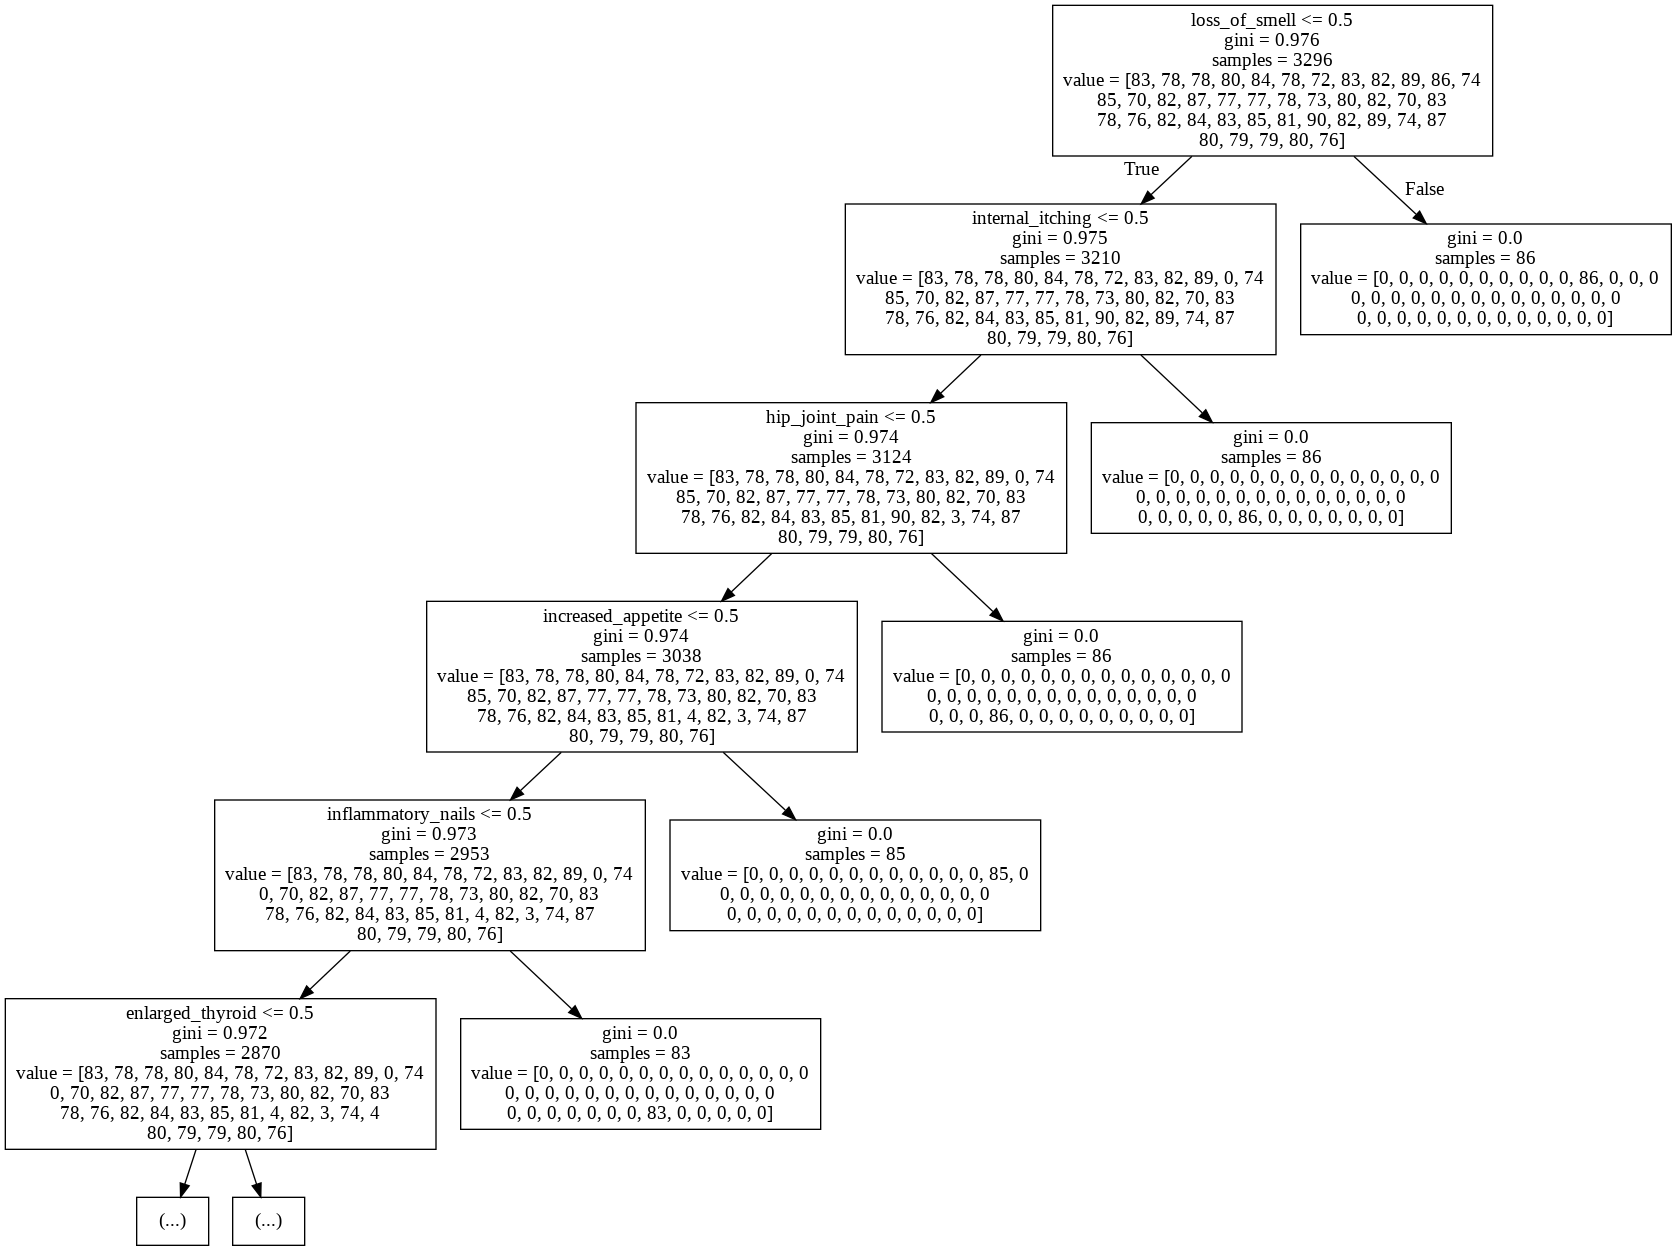

In [ ]:
from IPython.display import Image
Image(filename='tree-top5.png')

In [ ]:
feature_dict = {}
for i,f in enumerate(features):
    feature_dict[f] = i

In [ ]:
feature_dict['internal_itching']

93

In [ ]:
sample_x = [i/52 if i==52 else i*0 for i in range(len(features))]
cols = list(data.columns) 
print(cols.index('skin_rash'))

1


This means predicting the disease where the only symptom is redness_of_eyes.

In [ ]:
sample_x = np.array(sample_x).reshape(1,len(sample_x))

In [ ]:
dt.predict(sample_x)

array(['Dimorphic hemmorhoids(piles)'], dtype=object)

In [ ]:
dt.predict_proba(sample_x)

array([[0.        , 0.        , 0.        , 0.11764706, 0.        ,
        0.11764706, 0.        , 0.11764706, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.17647059, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.17647059, 0.        , 0.        , 0.17647059, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.11764706,
        0.        ]])

In [ ]:
len(sample_x)

1

In [ ]:
symptoms = ['skin_rash','itching','nodal_skin_eruptions','increased_appetite','irritability']
ipt = [0 for i in range(len(features))]
for s in symptoms:
  ipt[cols.index(s)]=1
ipt = np.array([ipt])
print(ipt)
print(dt.predict(ipt))
dt.predict_proba(ipt)

[[1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
['Diabetes ']


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.]])